In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
import statsmodels.formula.api as smf
import statsmodels.api as sm

DATA_FOLDER = 'Data/'
HOUSEHOLD_DATASET = DATA_FOLDER+'PisoFirme_AEJPol-20070024_household.dta'
INDIVIDUAL_DATASET = DATA_FOLDER+'PisoFirme_AEJPol-20070024_individual.dta'

household = pd.read_stata(HOUSEHOLD_DATASET)
individual = pd.read_stata(INDIVIDUAL_DATASET)

In [3]:
household.head(7)

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778
5,0.0,70000537.0,-103.50367,25.583067,7.0,41,0.3,0.036629,0.555554,819.0,...,25.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,4.605170,8.517193
6,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,18.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,5.857933,9.615806


In [4]:
individual.head(20)

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,S_age,S_gender,S_childma,S_childmaage,...,S_milkprogram,S_foodprogram,S_seguropopular,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
0,0.0,70000537.0,-103.503670,25.583067,7.0,47,1.0,0,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844
1,0.0,70000537.0,-103.503670,25.583067,7.0,40,37.0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1000.000000,0.0,53054.988281
2,0.0,70000537.0,-103.503670,25.583067,7.0,40,1.0,0,1.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1100.000000,0.0,52930.226562
3,0.0,70000537.0,-103.503670,25.583067,7.0,47,43.0,hombre,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,660.416687,0.0,30632.578125
4,0.0,70000537.0,-103.503670,25.583067,7.0,47,4.0,hombre,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844
5,0.0,70000537.0,-103.503670,25.583067,7.0,40,4.0,hombre,1.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,560.000000,60.0,21200.611328
6,0.0,70000537.0,-103.503670,25.583067,7.0,40,18.0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1100.000000,0.0,52930.226562
7,0.0,70000537.0,-103.503670,25.583067,7.0,40,3.0,0,0.0,NaN,...,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1108.333374,0.0,35087.679688
8,0.0,70000537.0,-103.503670,25.583067,7.0,47,5.0,hombre,1.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,660.416687,0.0,30632.578125
9,0.0,70000537.0,-103.503670,25.583067,7.0,40,30.0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,560.000000,60.0,21200.611328


In [5]:
temp = individual['S_childmaage'].copy()
msk = individual['S_childma'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childmaage'] = temp

In [6]:
temp = individual['S_childmaeduc'].copy()
msk = individual['S_childma'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childmaeduc'] = temp

In [7]:
temp = individual['S_childpaage'].copy()
msk = individual['S_childpa'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childpaage'] = temp

In [8]:
temp = individual['S_childpaeduc'].copy()
msk = individual['S_childpa'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childpaeduc'] = temp

# Data processing

### A few stats

In [9]:
print("We have ",len(household.index)," households.")
print("We have ", len(household.columns)," variables for households.")
print("How many missing values is there ? ", household.isna().any().sum())

We have  2783  households.
We have  78  variables for households.
How many missing values is there ?  51


In [10]:
print("We have ",len(individual.index)," individuals.")
print("We have ", len(individual.columns)," variables for individuals.")
print("How many missing values is there ? ", individual.isna().any().sum())

We have  6693  individuals.
We have  89  variables for individuals.
How many missing values is there ?  24


### Missing values

In [11]:
individual['S_gender'] = individual['S_gender'].apply(lambda x : 1 if type(x) == str else 0)

In [12]:
#Missing values will be imputed with a K-Nearest Neigbors algorithm
imputer = KNNImputer()

#Households
mod = imputer.fit(household)
H = pd.DataFrame(mod.transform(household))
H.columns = household.columns

#Individuals
temp = imputer.fit(individual)
I = pd.DataFrame(temp.transform(individual))
I.columns = individual.columns

In [13]:
H.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778


In [14]:
I.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,S_age,S_gender,S_childma,S_childmaage,...,S_milkprogram,S_foodprogram,S_seguropopular,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
0,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,1.0,0.0,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844
1,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,37.0,0.0,0.8,19.2,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1000.000000,0.0,53054.988281
2,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,1.0,0.0,1.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1100.000000,0.0,52930.226562
3,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,43.0,1.0,1.0,26.6,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,660.416687,0.0,30632.578125
4,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,4.0,1.0,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844


In [15]:
print("How many missing values is there ? ", H.isna().any().sum())
print("How many missing values is there ? ", I.isna().any().sum())

How many missing values is there ?  0
How many missing values is there ?  0


In [16]:
#No more missing values in the dataframes but we need to adjust some values because the KNN returns decimal numbers
#and features are categorical they only can be 0 or 1. We will take 1 if the value is above 0.5 and 0 otherwise. 
house_f = H.drop(['dpisofirme', 'idcluster', 'coord_x', 'coord_y', 'idmun', 'idmza', 'C_blocksdirtfloor', 
                  'C_HHdirtfloor', 'C_child05', 'C_rooms', 'C_HHpersons', 'C_waterland', 'C_waterhouse',
                  'C_waterbath', 'C_gasheater', 'C_refrigerator', 'C_washing', 'C_telephone', 'C_vehicle',
                  'C_overcrowding', 'C_poverty', 'C_illiterate', 'C_headeduc', 'C_dropouts515', 'C_employment',
                  'C_earnincome', 'S_cementfloor2000', 'S_incomepc', 'S_assetspc', 'S_shpeoplework', 'S_hrsworkedpc',
                  'S_consumptionpc', 'S_cashtransfers', 'S_dem1', 'S_dem2', 'S_dem3', 'S_dem4', 'S_dem5', 'S_dem6',
                  'S_dem7', 'S_dem8', 'S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat',
                  'S_cementfloorbed', 'S_logrent', 'S_logsell'], axis = 1).columns
indiv_f = I.drop(['dpisofirme', 'idcluster', 'coord_x', 'coord_y', 'idmun', 'idmza', 'S_haz', 'S_whz', 'S_malincom',
                 'S_palincom', 'S_incomepc', 'S_cashtransfers', 'S_assetspc'], axis = 1).columns

for f in house_f:
    H[f] = H[f].apply(lambda x : int(x) if abs(int(x)-x)<0.5 else int(x+1))
    
for f in indiv_f:
    I[f] = I[f].apply(lambda x : int(x) if abs(int(x)-x)<0.5 else int(x+1))

In [17]:
H.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,0.3,0.036629,0.555554,819,...,14,12,0,0,0,0,0,0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,0.3,0.036629,0.555554,819,...,17,24,0,0,0,0,0,0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40.0,0.3,0.036629,0.555554,819,...,16,16,0,0,0,0,0,0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,0.3,0.036629,0.555554,819,...,20,19,0,0,0,0,0,0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47.0,0.3,0.036629,0.555554,819,...,4,5,0,0,0,0,0,0,5.703783,10.819778


### Construction of the target

In [18]:
#We will generate a binary outcome vector indicating the global health status of the different persons. We will make 
#a combination of the different features about health.
#1 = health problems, 0 = good health
health = ['S_parcount', 'S_diarrhea', 'S_anemia', 'S_respira', 'S_skin', 'S_otherdis']

def target():
    N = len(I.index)
    target = []
    for n in range(N):
        if individual[health].loc[n].sum() >= 1:
            target.append(1)
        else:
            target.append(0)
    return target

target = pd.DataFrame(target())

### Normalization

In [19]:
to_norm = ['idcluster', 'coord_x', 'coord_y', 'idmun','idmza', 'S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage',
          'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_mccdts', 'S_pbdypct', 'S_haz', 'S_whz', 'S_malincom', 'S_palincom',
          'S_washhands', 'S_incomepc', 'S_cashtransfers', 'S_assetspc']
I[to_norm] = normalize(I[to_norm])

### Feature selection

In [20]:
selection = I.drop(['S_parcount', 'S_diarrhea', 'S_anemia', 'S_respira', 'S_skin', 'S_otherdis'], axis = 1)

In [21]:
selection = selection.drop(['idcluster', 'coord_x', 'coord_y', 'idmza', 'idmun'], axis = 1)

In [22]:
col = selection.columns
to_del = [j for j in col if not j.startswith('dtriage')]
selection = selection[to_del]

In [23]:
selection.head()

,dpisofirme,S_age,S_gender,S_childma,S_childmaage,S_childmaeduc,S_childpa,S_childpaage,S_childpaeduc,S_HHpeople,...,S_milkprogram,S_foodprogram,S_seguropopular,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
0,0.0,1.428560e-08,0,1,3.857113e-07,1.714272e-07,0,0.000000e+00,0.000000e+00,7.142802e-08,...,0,0,0,1,0,1,2.857121e-08,0.000000,0.0,0.000302
1,0.0,5.285672e-07,0,1,2.714264e-07,9.999920e-08,0,0.000000e+00,0.000000e+00,2.857120e-08,...,0,0,0,0,0,1,4.285680e-08,0.000014,0.0,0.000758
2,0.0,1.428560e-08,0,1,2.571408e-07,1.714272e-07,0,0.000000e+00,0.000000e+00,2.857120e-08,...,0,0,0,0,0,1,7.142800e-08,0.000016,0.0,0.000756
3,0.0,6.142809e-07,1,1,3.857113e-07,1.142848e-07,1,2.714265e-07,7.142802e-08,5.714241e-08,...,0,0,0,0,0,1,5.714241e-08,0.000009,0.0,0.000438
4,0.0,5.714242e-08,1,1,3.857113e-07,1.714272e-07,0,0.000000e+00,0.000000e+00,7.142802e-08,...,0,0,0,1,0,1,2.857121e-08,0.000000,0.0,0.000302


#### Pearson's correlation

In [24]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y, rowvar = False)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(selection, target, 15)
print(str(len(cor_feature)), 'selected features')
print("Selected features :", cor_feature)

15 selected features
Selected features : ['S_pbdypct', 'S_foodprogram', 'S_animalsinside', 'dpisofirme', 'S_hasanimals', 'S_childmaeduc', 'S_HHpeople', 'S_childpaeduc', 'S_haz', 'S_childmaage', 'S_childma', 'S_childpaage', 'S_childpa', 'S_gender', 'S_age']


Using a logistic regression, the accuracy is  0.6085657370517928
F1-score : 0.5218978102189782
Recall score : 0.5029308323563892
Precision_score : 0.5423514538558787


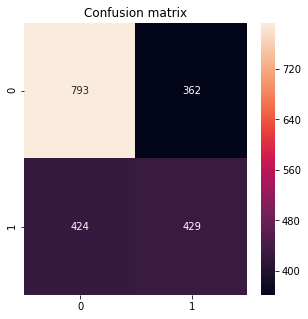

In [25]:
#Split data set between train and test
x_tr, x_te, y_tr, y_te = train_test_split(selection, np.ravel(target), test_size = 0.3, random_state = 50)

#Logistic regression
model = selection[cor_feature].columns
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 5000)
log_reg = logistic.fit(x_tr[model], y_tr)
pred = log_reg.predict(x_te[model])

#Statistics
print('Using a logistic regression, the accuracy is ', accuracy_score(y_te, pred))
print('F1-score :', f1_score(y_te, pred))
print('Recall score :', recall_score(y_te, pred))
print('Precision_score :', precision_score(y_te, pred))

#Confusion matrix
matrix = confusion_matrix(y_te, pred)
plt.figure(figsize = (5, 5))
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.show()

#### Chi-2

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(selection)
chi_selector = SelectKBest(chi2, k=15)
chi_selector.fit(X_norm, target)
chi_support = chi_selector.get_support()
chi_feature = selection.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print("Selected features :", chi_feature)

15 selected features
Selected features : ['dpisofirme', 'S_age', 'S_gender', 'S_childma', 'S_childmaage', 'S_childmaeduc', 'S_childpa', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_haz', 'S_foodprogram', 'S_seguropopular', 'S_hasanimals', 'S_animalsinside']


Using a logistic regression, the accuracy is  0.6090637450199203
F1-score : 0.5210494203782795
Recall score : 0.5005861664712778
Precision_score : 0.5432569974554707


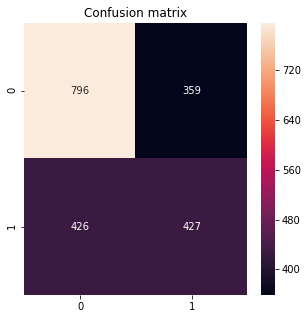

In [27]:
#Split data set between train and test
x_tr, x_te, y_tr, y_te = train_test_split(selection, np.ravel(target), test_size = 0.3, random_state = 50)

#Logistic regression
model = selection[chi_feature].columns
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 5000)
log_reg = logistic.fit(x_tr[model], y_tr)
pred = log_reg.predict(x_te[model])

#Statistics
print('Using a logistic regression, the accuracy is ', accuracy_score(y_te, pred))
print('F1-score :', f1_score(y_te, pred))
print('Recall score :', recall_score(y_te, pred))
print('Precision_score :', precision_score(y_te, pred))

#Confusion matrix
matrix = confusion_matrix(y_te, pred)
plt.figure(figsize = (5, 5))
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.show()

#### LightGBM

In [30]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=15)
embeded_lgb_selector.fit(selection, target)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = selection.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')
print(embeded_lgb_feature)

/home/hugo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


15 selected features
['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_mccdts', 'S_haz', 'S_whz', 'S_malincom', 'S_palincom', 'S_washhands', 'S_incomepc', 'S_assetspc']


Using a logistic regression, the accuracy is  0.575199203187251
F1-score : 0.0
Recall score : 0.0
Precision_score : 0.0


/home/hugo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


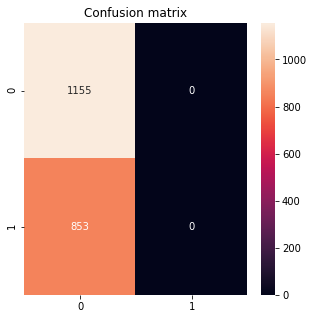

In [31]:
#Split data set between train and test
x_tr, x_te, y_tr, y_te = train_test_split(selection, np.ravel(target), test_size = 0.3, random_state = 50)

#Logistic regression
model = selection[embeded_lgb_feature].columns
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 5000)
log_reg = logistic.fit(x_tr[model], y_tr)
pred = log_reg.predict(x_te[model])

#Statistics
print('Using a logistic regression, the accuracy is ', accuracy_score(y_te, pred))
print('F1-score :', f1_score(y_te, pred))
print('Recall score :', recall_score(y_te, pred))
print('Precision_score :', precision_score(y_te, pred))

#Confusion matrix
matrix = confusion_matrix(y_te, pred)
plt.figure(figsize = (5, 5))
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.show()

#### RFE

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(max_iter = 5000), n_features_to_select=15, step=10, verbose=5)
rfe_selector.fit(X_norm, np.ravel(target))
rfe_support = rfe_selector.get_support()
rfe_feature = selection.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 30 features.
Fitting estimator with 20 features.
15 selected features
['dpisofirme', 'S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpa', 'S_childpaage', 'S_HHpeople', 'S_rooms', 'S_mccdts', 'S_haz', 'S_palincom', 'S_seguropopular', 'S_washhands', 'S_incomepc', 'S_cashtransfers']


Using a logistic regression, the accuracy is  0.6055776892430279
F1-score : 0.3366834170854272
Recall score : 0.23563892145369286
Precision_score : 0.5894428152492669


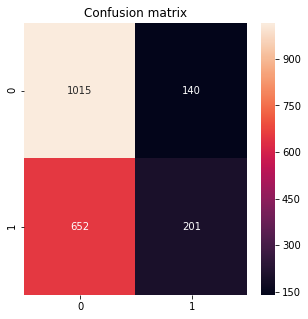

In [33]:
#Split data set between train and test
x_tr, x_te, y_tr, y_te = train_test_split(selection, np.ravel(target), test_size = 0.3, random_state = 50)

#Logistic regression
model = selection[rfe_feature].columns
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 5000)
log_reg = logistic.fit(x_tr[model], y_tr)
pred = log_reg.predict(x_te[model])

#Statistics
print('Using a logistic regression, the accuracy is ', accuracy_score(y_te, pred))
print('F1-score :', f1_score(y_te, pred))
print('Recall score :', recall_score(y_te, pred))
print('Precision_score :', precision_score(y_te, pred))

#Confusion matrix
matrix = confusion_matrix(y_te, pred)
plt.figure(figsize = (5, 5))
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.show()

#### Random Forest

In [34]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=15)
embeded_rf_selector.fit(selection, np.ravel(target))

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = selection.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

7 selected features
['S_age', 'S_gender', 'S_childpa', 'S_pbdypct', 'S_incomepc', 'S_cashtransfers', 'S_assetspc']


Using a logistic regression, the accuracy is  0.6030876494023905
F1-score : 0.5040448039825762
Recall score : 0.47479484173505276
Precision_score : 0.5371352785145889


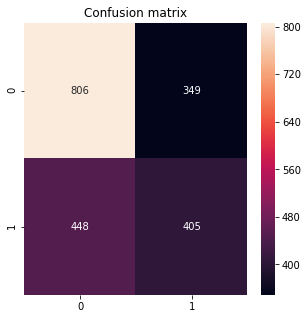

In [35]:
#Split data set between train and test
x_tr, x_te, y_tr, y_te = train_test_split(selection, np.ravel(target), test_size = 0.3, random_state = 50)

#Logistic regression
model = selection[embeded_rf_feature].columns
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 5000)
log_reg = logistic.fit(x_tr[model], y_tr)
pred = log_reg.predict(x_te[model])

#Statistics
print('Using a logistic regression, the accuracy is ', accuracy_score(y_te, pred))
print('F1-score :', f1_score(y_te, pred))
print('Recall score :', recall_score(y_te, pred))
print('Precision_score :', precision_score(y_te, pred))

#Confusion matrix
matrix = confusion_matrix(y_te, pred)
plt.figure(figsize = (5, 5))
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.show()

#### Lasso regularization

Best alpha using built-in LassoCV: 0.001303
Best score using built-in LassoCV: 0.044097
Lasso picked 5 variables and eliminated the other 25 variables


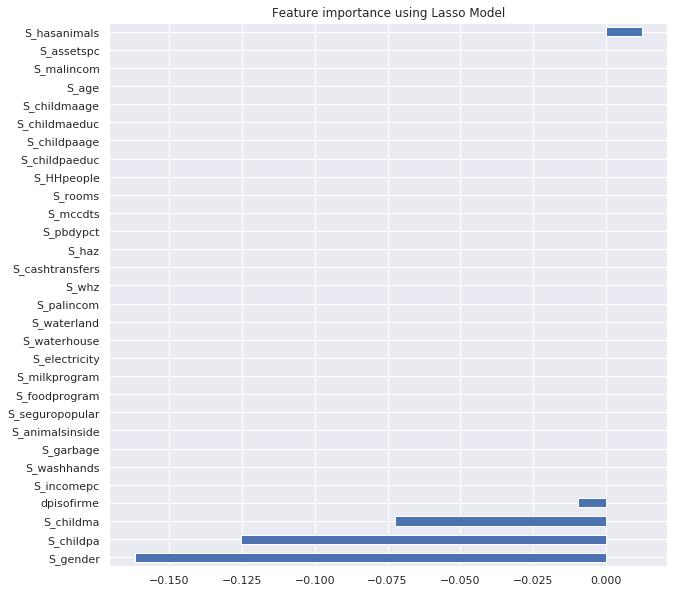

Selected features : ['S_gender', 'S_childpa', 'S_childma', 'dpisofirme', 'S_hasanimals']


In [36]:
#Lasso regularization
from sklearn.linear_model import LassoCV, Lasso

reg = LassoCV(max_iter = 10000)
reg_ = reg.fit(selection, np.ravel(target))
print("Best alpha using built-in LassoCV: %f" % reg_.alpha_)
print("Best score using built-in LassoCV: %f" %reg_.score(selection, np.ravel(target)))
coef = pd.Series(reg_.coef_, index = selection.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")
sns.set()
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

kept = imp_coef[[imp_coef[i] != 0 for i in range(len(imp_coef))]]
lasso_feature = selection[kept.index].columns.tolist()

print("Selected features :", lasso_feature)

Using a logistic regression, the accuracy is  0.6070717131474104
F1-score : 0.5150583896742471
Recall score : 0.4912075029308324
Precision_score : 0.541343669250646


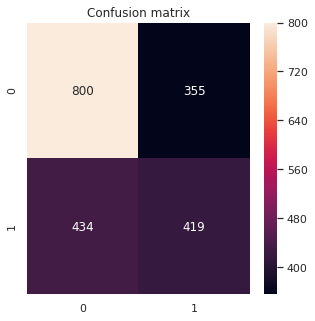

In [37]:
#Split data set between train and test
x_tr, x_te, y_tr, y_te = train_test_split(selection, np.ravel(target), test_size = 0.3, random_state = 50)

#Logistic regression
model = selection[lasso_feature].columns
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 5000)
log_reg = logistic.fit(x_tr[model], y_tr)
pred = log_reg.predict(x_te[model])

#Statistics
print('Using a logistic regression, the accuracy is ', accuracy_score(y_te, pred))
print('F1-score :', f1_score(y_te, pred))
print('Recall score :', recall_score(y_te, pred))
print('Precision_score :', precision_score(y_te, pred))

#Confusion matrix
matrix = confusion_matrix(y_te, pred)
plt.figure(figsize = (5, 5))
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.show()

### Overview of feature selection

In [38]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':selection.columns, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)

,Feature,Pearson,Chi-2,RFE,Random Forest,LightGBM,Total
1,S_age,True,True,True,True,True,5
2,S_haz,True,True,True,False,True,4
3,S_childpaage,True,True,True,False,True,4
4,S_childpa,True,True,True,True,False,4
5,S_childmaeduc,True,True,True,False,True,4
6,S_childmaage,True,True,True,False,True,4
7,S_HHpeople,True,True,True,False,True,4
8,dpisofirme,True,True,True,False,False,3
9,S_incomepc,False,False,True,True,True,3
10,S_gender,True,True,False,True,False,3


In [58]:

features= feature_selection_df.ix[:14,'Feature']
features_list=features.tolist()
x_tr, x_te, y_tr, y_te = train_test_split(selection[features], np.ravel(target), test_size = 0.3, random_state = 50)
# building the model and fitting the data 
log_reg = sm.Logit(y_tr, x_tr).fit() 
print(log_reg.summary())
selected_features=features[log_reg.pvalues.apply(lambda x: x<0.5 ).to_numpy()]

         Current function value: 1.479890
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4685
Model:                          Logit   Df Residuals:                     4671
Method:                           MLE   Df Model:                           13
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                  -1.155
Time:                        19:31:30   Log-Likelihood:                -6933.3
converged:                      False   LL-Null:                       -3217.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
S_age            1.426e+04   3.48e+05      0.041      0.967   -6.68e+05    6.97e+05
S_haz              15.1044   4.68e+06   3.23e-06  

/home/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/hugo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [69]:
x_tr, x_te, y_tr, y_te = train_test_split(selection[selected_features.tolist()], np.ravel(target), test_size = 0.3, random_state = 50)
# building the model and fitting the data 
log_reg = sm.Logit(y_tr, x_tr).fit() 
print(log_reg.summary())

         Current function value: 1.478763
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4685
Model:                          Logit   Df Residuals:                     4680
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                  -1.154
Time:                        19:36:41   Log-Likelihood:                -6928.0
converged:                      False   LL-Null:                       -3217.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
S_childpa          -4.0555      0.152    -26.648      0.000      -4.354      -3.757
dpisofirme          3.2273      0.133     24.199  

/home/hugo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
